Problem is, we should only update 'conn' and not 'wMat'

In [1]:
# Two Stage Training: topology search with NEAT, weight search with backprop (essentially replacing SNeat)
# - for simplicity, let's pick best few species at the end of NEAT stage, and do backprop on them, then select the best one and propagate into NEAT stage to do further search 
# - this way we reduce the workload a bit and have a more clear separation between the stages ... since we know SNeat works well for SlimeVolleyBall 


from fineNeat import Neat 
from fineNeat import loadHyp, updateHyp, load_cls_task
from neat_backprop.datagen import DataGenerator
from neat_backprop.tune import get_reward

choice_id = 0
generator = DataGenerator(train_size=2000, batch_size=1000)
train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset


hyp_default = '../fineNeat/fineNeat/p/cls.json'
hyp_adjust = '../fineNeat/fineNeat/p/cls_neat.json'
fileName = "cls"

hyp = loadHyp(pFileName=hyp_default, load_task=load_cls_task)
updateHyp(hyp,load_cls_task,hyp_adjust)

In [2]:
from neat_backprop.datagen import DataGenerator
from fineNeat.sneat_jax.ind import Ind

generator = DataGenerator(train_size=2000, test_size=1000, batch_size=1000)
choice_id = 0
nInput = 2
nOutput = 2 

train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset

ind = Ind.from_shapes([(nInput,nOutput)], act_id=9)
ind.express()

True

In [4]:
ind.safe_mutate(0)

In [4]:
# ind.safe_mutate(hyp)

seed = 0 
import jax 
self = ind 
conn = self.conn 
key = jax.random.PRNGKey(seed)  # Added key for random number generation
conn = conn.at[3, :].set(conn[3] + jax.random.normal(key, shape=(conn[3].shape)) * 0.1)

In [6]:
node = self.node 
child = Ind(conn, node) 

In [7]:
child.express()

True

In [3]:
# Evolve multiple times and train it
from tqdm import tqdm 

pop = [ind] 
for i in tqdm(range(12)): 
    child, _ = ind.mutate(hyp)
    if child.express(): 
        print("Evolved Child")
        ind = child
        pop.append(ind)

  8%|▊         | 1/12 [00:01<00:11,  1.02s/it]

Evolved Child


 17%|█▋        | 2/12 [00:01<00:09,  1.05it/s]

Evolved Child


 25%|██▌       | 3/12 [00:02<00:08,  1.12it/s]

Evolved Child


 33%|███▎      | 4/12 [00:03<00:07,  1.08it/s]

Evolved Child


 42%|████▏     | 5/12 [00:04<00:06,  1.14it/s]

Evolved Child


 50%|█████     | 6/12 [00:05<00:05,  1.13it/s]

Evolved Child


 58%|█████▊    | 7/12 [00:06<00:04,  1.10it/s]

Evolved Child


 67%|██████▋   | 8/12 [00:07<00:03,  1.05it/s]

Evolved Child


 75%|███████▌  | 9/12 [00:08<00:02,  1.09it/s]

Evolved Child


 83%|████████▎ | 10/12 [00:09<00:01,  1.04it/s]

Evolved Child


 92%|█████████▏| 11/12 [00:10<00:00,  1.05it/s]

Evolved Child


100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

Evolved Child


Training (Loss: 0.2443): 100%|██████████| 600/600 [00:22<00:00, 26.80it/s]


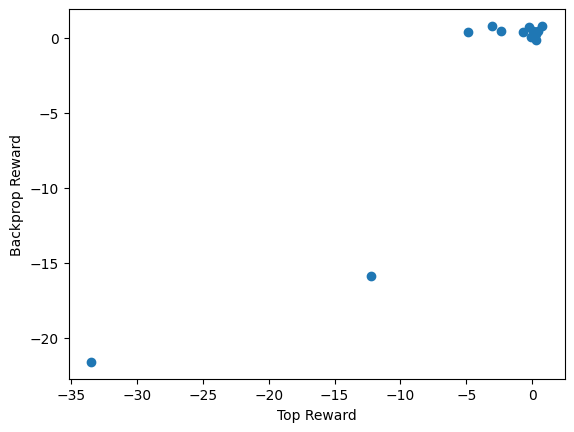

In [4]:
from neat_backprop.tune import get_reward, train_ind

top_reward = get_reward(pop, test_data, nInput=2, nOutput=2)

for i in range(len(pop)): 
    pop[i].fitness = top_reward[i]
    
# Sort the population by fitness
sorted_pop = sorted(pop, key=lambda x: x.fitness, reverse=False)
top_reward = [pop.fitness for pop in sorted_pop]

trained_pop = []
for i in range(len(sorted_pop)): 
    trained_ind, _ = train_ind(sorted_pop[i], train_data, generator, learning_rate=0.01, n_epochs=600, interval=50, nInput=2, nOutput=2)
    trained_pop.append(trained_ind)     

backprop_reward = get_reward(trained_pop, test_data, nInput=2, nOutput=2)

# Plot on x axis: top_reward, on y axis: backprop_reward
import matplotlib.pyplot as plt
plt.scatter(top_reward, backprop_reward)
plt.xlabel("Top Reward")
plt.ylabel("Backprop Reward")
plt.show()

In [ ]:
# Simplified Algorithm: 
# 1. Pick top 9 individuals from population (according to fitness), train them with backprop
# 2. Select best 3, kill all the other populations and replace them with mutated version of the best 3. 

# initial population
from neat_backprop.simpop import SimplePop

ind = Ind.from_shapes([(nInput,nOutput)], act_id=9) 
ind.express()
pop_size = 96


# Initialize Population 
pop = SimplePop(ind, pop_size, hyp)

for iter in range(10): 
    reward = get_reward(pop.population, test_data, nInput=2, nOutput=2)
    top_k = pop.tell_pop(reward, k=9)
    top_k = pop.train_n_pick(top_k, k=3)
    pop.update_pop(top_k, power = (iter+1)//2)

Top 9 network topology fitness at generation 1:  [0.7472078502178192, 0.6419116258621216, 0.5988534390926361, 0.5988534390926361, 0.5988534390926361, 0.5988534390926361, 0.4935572147369385, 0.4935572147369385, 0.4935572147369385]


Training (Loss: 0.4576): 100%|██████████| 600/600 [00:13<00:00, 44.02it/s]


Backprop reward:  [0.7700730264186859, 0.7024675905704498, 0.6041597127914429, 0.6040540039539337, 0.6043097376823425, 0.6042369306087494, 0.5367175042629242, 0.5364205539226532, 0.5364978909492493]
Top 3 backprop fitness at generation 1:  [0.7700730264186859, 0.7024675905704498, 0.6043097376823425]
Generating 2 generation from top k individuals
Top 9 network topology fitness at generation 2:  [0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859]


Training (Loss: 0.1962): 100%|██████████| 600/600 [00:13<00:00, 43.23it/s]


Backprop reward:  [0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265]
Top 3 backprop fitness at generation 2:  [0.801816537976265, 0.801816537976265, 0.801816537976265]
Generating 3 generation from top k individuals
Top 9 network topology fitness at generation 3:  [0.8038240522146225, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.8003725707530975, 0.7990263253450394, 0.7985842078924179, 0.7585892230272293, 0.756359875202179]


Training (Loss: 0.1471): 100%|██████████| 600/600 [00:15<00:00, 37.73it/s]


Backprop reward:  [0.8202472925186157, 0.8021197766065598, 0.8021197766065598, 0.8021197766065598, 0.8833929672837257, 0.8187918663024902, 0.8186816573143005, 0.8536011874675751, 0.853670060634613]
Top 3 backprop fitness at generation 3:  [0.8833929672837257, 0.853670060634613, 0.8536011874675751]
Generating 4 generation from top k individuals
Top 9 network topology fitness at generation 4:  [0.8833929672837257, 0.853670060634613, 0.8536011874675751, 0.7683807760477066, 0.7642704099416733, 0.7519461214542389, 0.7291935086250305, 0.6934500634670258, 0.6878142058849335]


Training (Loss: 0.2452): 100%|██████████| 600/600 [00:18<00:00, 31.84it/s]


Backprop reward:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076, 0.7999453395605087, 0.7807717323303223, 0.7683710008859634, 0.5996142327785492, 0.7997927814722061, 0.7757631093263626]
Top 3 backprop fitness at generation 4:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076]
Generating 5 generation from top k individuals
Top 9 network topology fitness at generation 5:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076, 0.7745161801576614, 0.7194724678993225, 0.6848058104515076, 0.6751083135604858, 0.6664944887161255, 0.6355188488960266]


Training (Loss: 0.2366): 100%|██████████| 600/600 [00:20<00:00, 28.62it/s]


Backprop reward:  [0.886697567999363, 0.8557724803686142, 0.854949489235878, 0.7951219081878662, 0.7440501749515533, 0.7570898979902267, 0.7586332261562347, 0.710210382938385, 0.7754668146371841]
Top 3 backprop fitness at generation 5:  [0.886697567999363, 0.8557724803686142, 0.854949489235878]
Generating 6 generation from top k individuals
Top 9 network topology fitness at generation 6:  [0.886697567999363, 0.8557724803686142, 0.854949489235878, 0.7316596210002899, 0.7219150066375732, 0.7210363745689392, 0.7084838449954987, 0.662297397851944, 0.6020506918430328]


Training (Loss: 0.1767): 100%|██████████| 600/600 [00:21<00:00, 27.84it/s]


Backprop reward:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069, 0.8458722978830338, 0.837649017572403, 0.8509677797555923, 0.8188500106334686, 0.7815341204404831, 0.827145591378212]
Top 3 backprop fitness at generation 6:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069]
Generating 7 generation from top k individuals
Top 9 network topology fitness at generation 7:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069, 0.7658727169036865, 0.7156431376934052, 0.7121657133102417, 0.6828709542751312, 0.6406593322753906, 0.6377338767051697]


Training (Loss: 0.1088):  55%|█████▍    | 327/600 [00:09<00:07, 35.63it/s]


KeyboardInterrupt: 

In [30]:
reward = get_reward(pop.population, test_data, nInput=2, nOutput=2)
top_k = pop.tell_pop(reward, k=9)

Top 9 network topology fitness at generation 7:  [0.8874381557106972, 0.855619803071022, 0.8547805994749069, 0.7658727169036865, 0.7156431376934052, 0.7121657133102417, 0.6828709542751312, 0.6406593322753906, 0.6377338767051697]


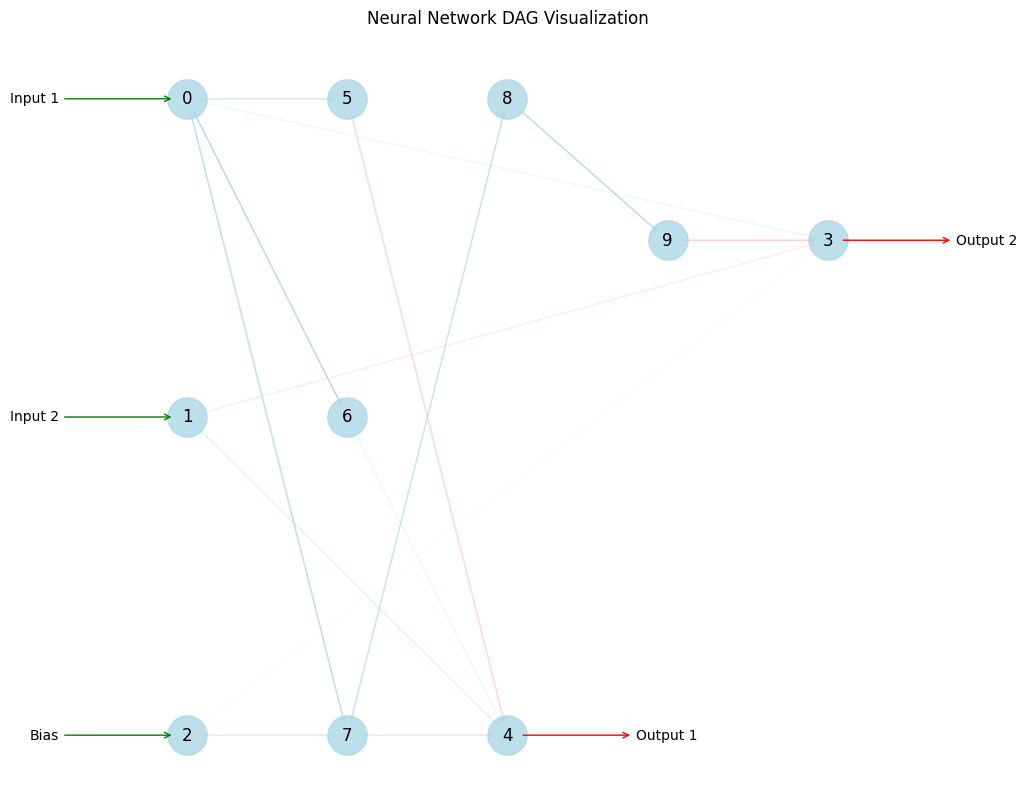

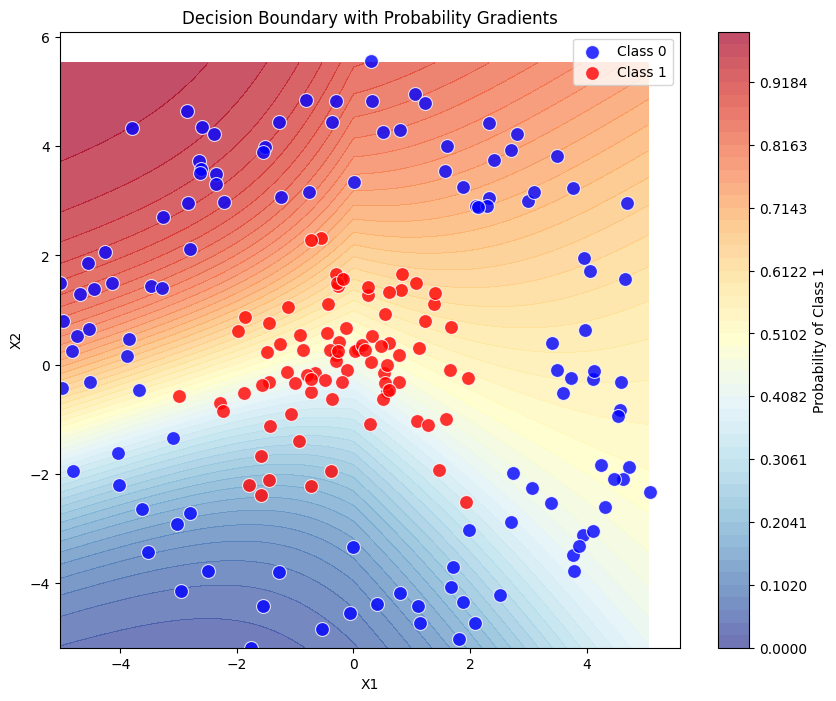

In [42]:
from fineNeat import viewInd, fig2img 
from neat_backprop.viz import plot_decision_boundary
import matplotlib.pyplot as plt
ind = top_k[8]
viewInd(ind)
fig, ax = plot_decision_boundary(ind.wMat, ind.aVec, nInput, nOutput, test_data[::5])
img = fig2img(fig)


NEAT-backprop training on classification dataset

In [1]:
# Two Stage Training: topology search with NEAT, weight search with backprop (essentially replacing SNeat)
# - for simplicity, let's pick best few species at the end of NEAT stage, and do backprop on them, then select the best one and propagate into NEAT stage to do further search 
# - this way we reduce the workload a bit and have a more clear separation between the stages ... since we know SNeat works well for SlimeVolleyBall 


from fineNeat import Neat 
from fineNeat import loadHyp, updateHyp, load_cls_task
from neat_backprop.datagen import DataGenerator
from neat_backprop.tune import get_reward

choice_id = 0
generator = DataGenerator(train_size=2000, batch_size=1000)
train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset


hyp_default = '../fineNeat/fineNeat/p/cls.json'
hyp_adjust = '../fineNeat/fineNeat/p/cls_neat.json'
fileName = "cls"

hyp = loadHyp(pFileName=hyp_default, load_task=load_cls_task)
updateHyp(hyp,load_cls_task,hyp_adjust)

Two-Stage neat-backprop 
* Stage 1: NEAT topology search 
* Stage 2: Backprop on top individuals per species

In [15]:
from neat_backprop.tune import get_reward, jnp, train_ind
from fineNeat.sneat_jax.ind import Ind 

def train_species(self, species): 
    species = self.species 
    spec_individuals = [spec.seed for spec in species]
    from neat_backprop.tune import train_ind 
    trained_individuals = []
    for ind in spec_individuals: 
        trained_ind, _ = train_ind(ind, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)
        trained_individuals.append(trained_ind)
    for i in range(len(species)): 
        self.species[i].seed = trained_individuals[i]
        self.species[i].bestInd = trained_individuals[i]
        self.species[i].members.append(trained_individuals[i])
    self.pop += trained_individuals 


# Step 1: NEAT topology search 
# Step 2: Backpop on all species within NEAT to replace best individual 
# Iterate 1-2 

# Iterate 2-stage neat-backprop 
# First Stage features NEAT topology search 
neat = Neat(hyp)

neat.initPop()
for iter in range(31): 
    pop = neat.ask()
    if iter > 0 and iter % 30 == 0: 
        train_species(neat, neat.species) # train species and add it to the population 
    reward = get_reward(pop, test_data, nInput=2, nOutput=2)
    print("Best reward: ", max(reward))
    neat.tell(reward)
    
train_species(neat, neat.species)
best_ind = sorted(neat.pop, key=lambda x: x.fitness, reverse=True)[0]
best_ind = Ind(node=jnp.array(best_ind.node), conn=jnp.array(best_ind.conn))
best_ind.express()

 :: Number of species:  0
 :: - Adjust spec_thresh to  0.7
Best reward:  0.24780231714248657
 :: Number of species:  4
 :: - Adjust spec_thresh to  0.49999999999999994
Best reward:  0.5397655069828033
 :: Number of species:  24
 :: - Adjust spec_thresh to  0.7
Best reward:  0.5397655069828033
 :: Number of species:  22
 :: - Adjust spec_thresh to  0.8999999999999999
Best reward:  0.5642696619033813
 :: Number of species:  24
 :: - Adjust spec_thresh to  1.0999999999999999
Best reward:  0.586955726146698
 :: Number of species:  21
 :: - Adjust spec_thresh to  1.2999999999999998
Best reward:  0.586955726146698
 :: Number of species:  17
 :: - Adjust spec_thresh to  1.4999999999999998
Best reward:  0.586955726146698
 :: Number of species:  7
 :: - Adjust spec_thresh to  1.2999999999999998
Best reward:  0.5870679318904877
 :: Number of species:  10
 :: - Adjust spec_thresh to  1.4999999999999998
Best reward:  0.5892320871353149
 :: Number of species:  7
 :: - Adjust spec_thresh to  1.29999

Training (Loss: 0.4610): 100%|██████████| 800/800 [00:29<00:00, 27.55it/s]


Best reward:  0.6964627802371979


Training (Loss: 0.4574): 100%|██████████| 800/800 [00:26<00:00, 30.42it/s]


True

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Neural Network DAG Visualization'}>)

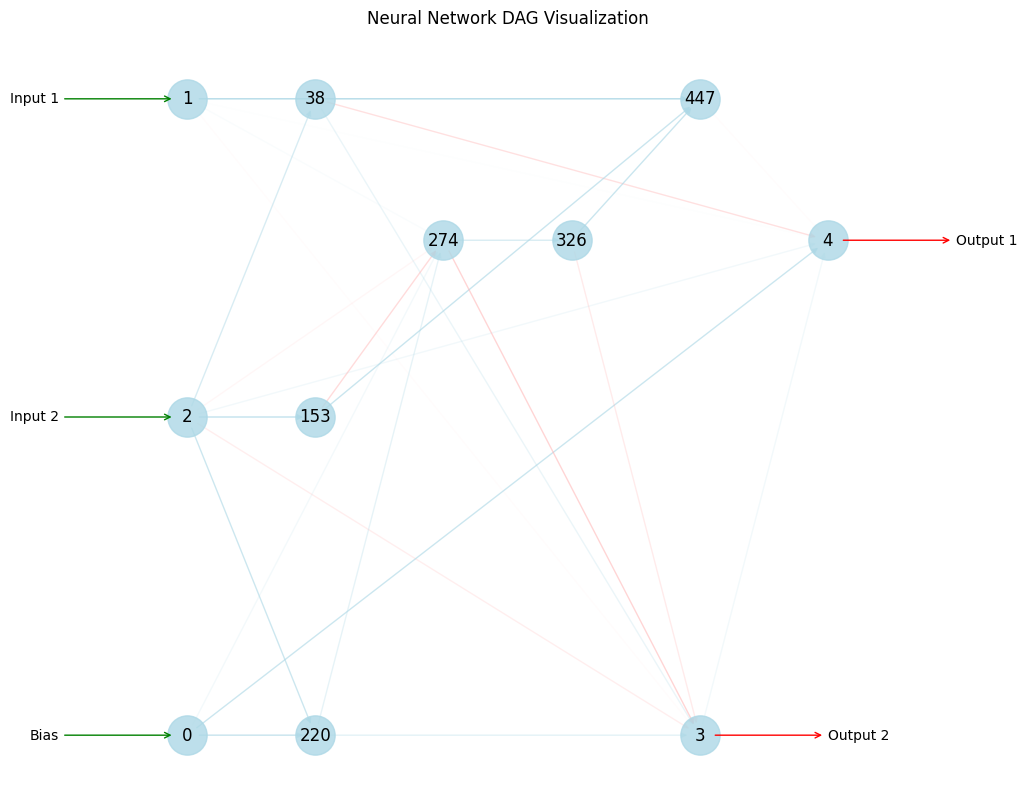

In [13]:
# neat.printSpecies(neat.species)
best_ind = sorted(neat.pop, key=lambda x: x.fitness, reverse=True)[0]
best_ind = Ind(node=jnp.array(best_ind.node), conn=jnp.array(best_ind.conn))
best_ind.express()

from fineNeat import viewInd 
viewInd(best_ind)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

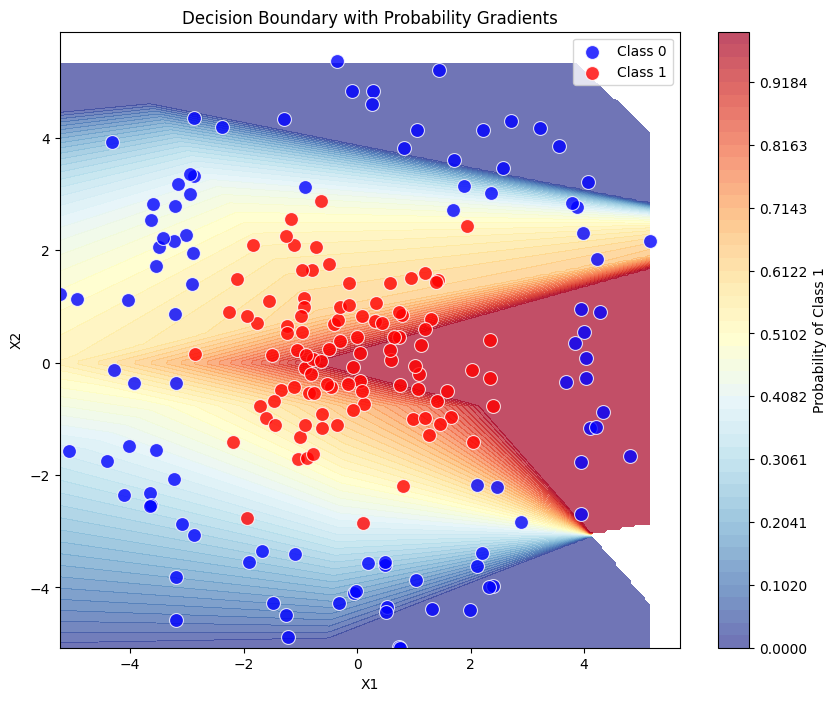

In [14]:
from neat_backprop.viz import plot_decision_boundary
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput=2, nOutput=2, data=test_data)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

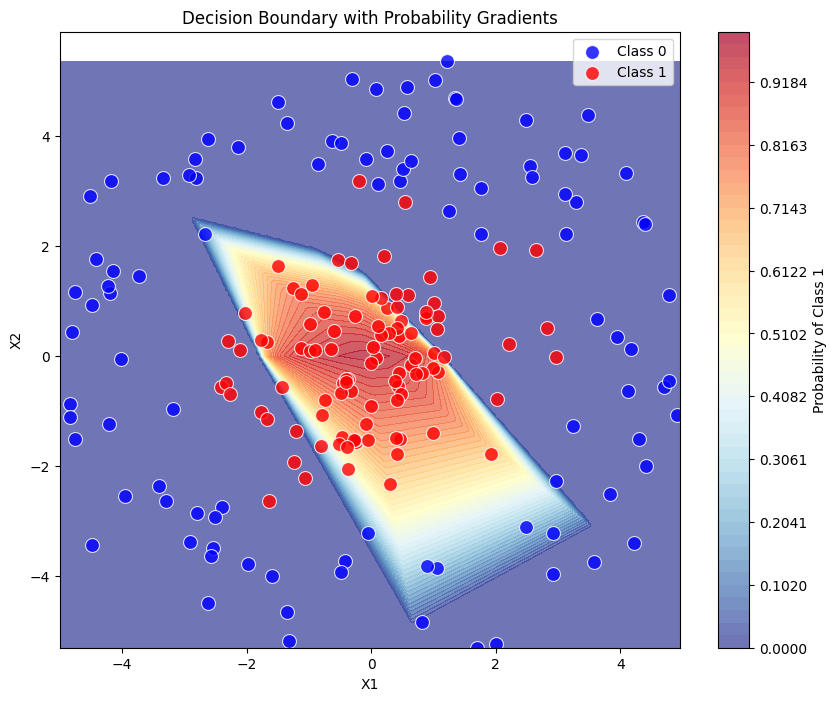

In [9]:
from fineNeat.sneat_jax.ind import Ind 

import random 
# k = nodeG.shape[1]
k = 10
random.choices([1,3,4,5,6,7,8,9,10,11], k=k)

[5, 9, 9, 6, 3, 5, 1, 11, 10, 5]

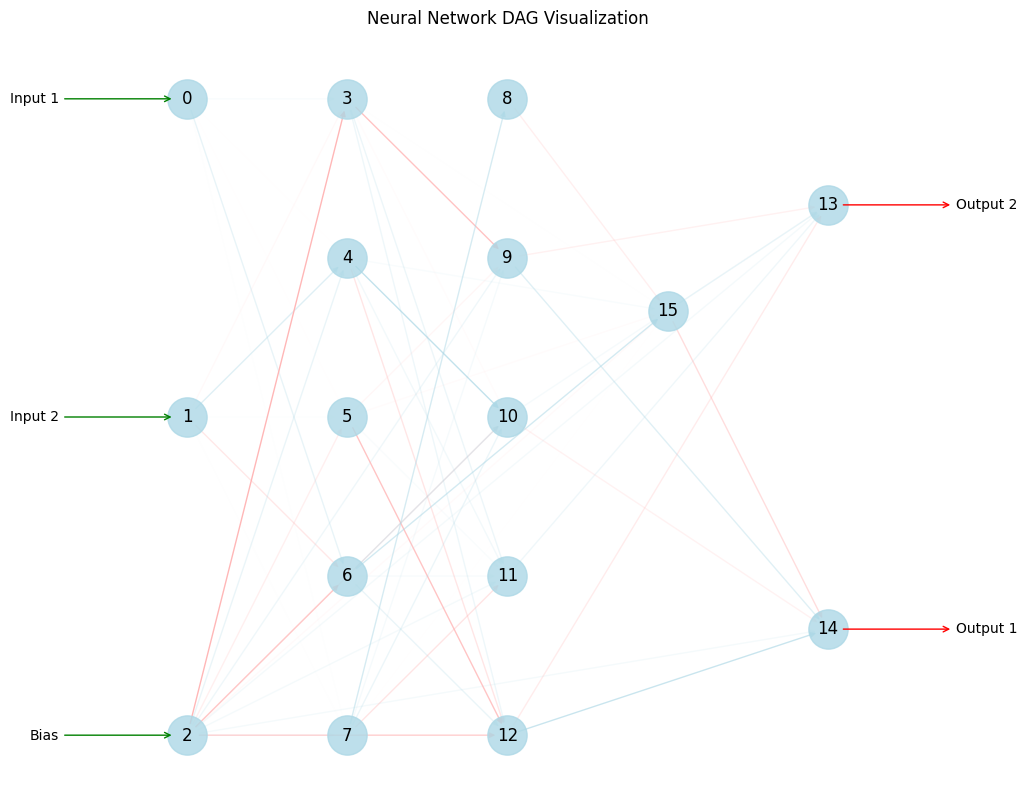

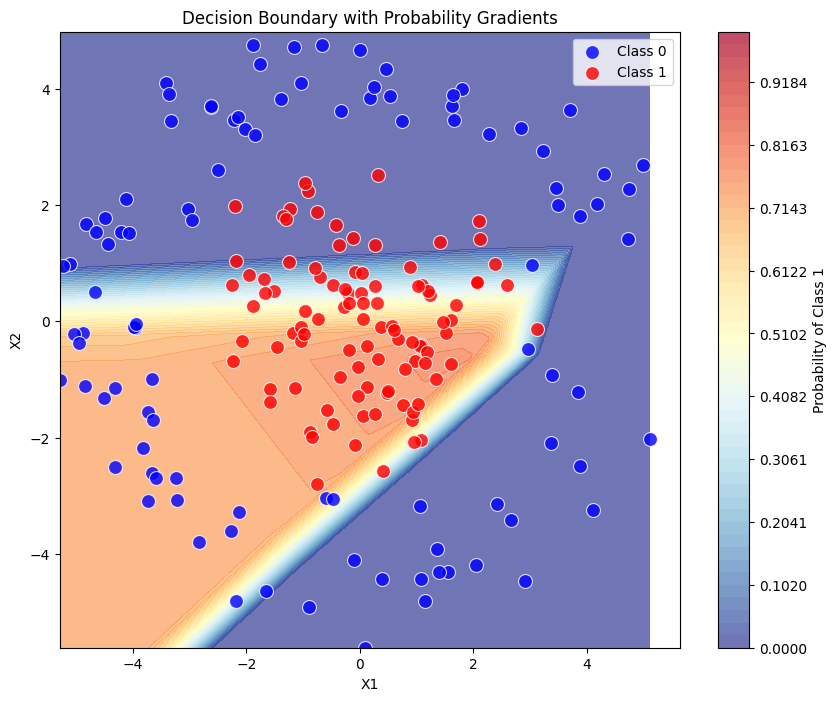

In [4]:
from fineNeat import viewInd 
viewInd(best_ind)

from viz import plot_decision_boundary
nInput, nOutput = 2, 2
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


In [7]:
fig, ax = plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


NameError: name 'best_ind' is not defined

In [9]:
from slimevolleygym.mlp import games as games
game=games['slimevolleylite']

# game['input_size'], game['output_size']
game.input_size, game.output_size

(12, 3)